**data_fetcher**

In [1]:
pip install sentinelhub torch torchvision matplotlib numpy pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.1/250.1 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.3 MB/s eta 0:00:00


In [2]:
import os

CSV_PATH = "/content/drive/MyDrive/Colab Notebooks/train(1).csv"
IMG_DIR = "/content/drive/MyDrive/Colab Notebooks/sentinel images"

os.makedirs(IMG_DIR, exist_ok=True)

print("CSV exists:", os.path.exists(CSV_PATH))
print("IMG_DIR exists:", os.path.exists(IMG_DIR))


CSV exists: True
IMG_DIR exists: True


In [3]:
import pandas as pd

df = pd.read_csv(CSV_PATH)
print(df.columns)
print(df.head())

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')
           id             date   price  bedrooms  bathrooms  sqft_living  \
0  9117000170  20150505T000000  268643         4       2.25         1810   
1  6700390210  20140708T000000  245000         3       2.50         1600   
2  7212660540  20150115T000000  200000         4       2.50         1720   
3  8562780200  20150427T000000  352499         2       2.25         1240   
4  7760400350  20141205T000000  232000         3       2.00         1280   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      9240     2.0           0     0  ...      7        1810              0   
1      2788     2.0           0     0  ...      7        1600              0   
2      

config

In [4]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = "c37f6bf3-f8cb-4cfa-b68e-1bb9910bd8e8"
config.sh_client_secret = "5kIqx5hM7DQrSIOH1fy9sY5M6YNiLv6t"

print("Sentinel Hub config set")

Sentinel Hub config set


sentinel images

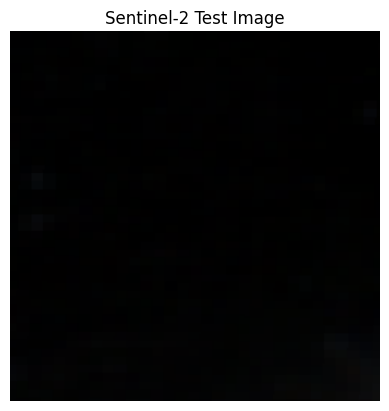

In [5]:
from sentinelhub import (
    SentinelHubRequest,
    DataCollection,
    MimeType,
    CRS,
    BBox
)
import matplotlib.pyplot as plt

row = df.iloc[0]
lat, lon = row["lat"], row["long"]

bbox = BBox(
    bbox=[lon-0.002, lat-0.002, lon+0.002, lat+0.002],
    crs=CRS.WGS84
)

request = SentinelHubRequest(
    evalscript="""
    //VERSION=3
    function setup() {
        return {
            input: ["B02", "B03", "B04"],
            output: { bands: 3 }
        };
    }
    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
    """,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=("2023-01-01", "2023-12-31"),
            mosaicking_order="mostRecent"
        )
    ],
    responses=[
        SentinelHubRequest.output_response("default", MimeType.PNG)
    ],
    bbox=bbox,
    size=(224, 224),
    config=config
)

image = request.get_data()[0]

plt.imshow(image)
plt.axis("off")
plt.title("Sentinel-2 Test Image")
plt.show()

In [7]:
import matplotlib.pyplot as plt

img_path = os.path.join(IMG_DIR, "0_sentinel.png")
plt.imsave(img_path, image)

print("Saved image:", img_path)

Saved image: /content/drive/MyDrive/Colab Notebooks/sentinel images/0_sentinel.png


In [8]:
from tqdm import tqdm

for idx, row in tqdm(df.iterrows(), total=len(df)):
    lat, lon = row["lat"], row["long"]

    bbox = BBox(
        bbox=[lon-0.002, lat-0.002, lon+0.002, lat+0.002],
        crs=CRS.WGS84
    )

    request = SentinelHubRequest(
        evalscript="""
        //VERSION=3
        function setup() {
            return {
                input: ["B02", "B03", "B04"],
                output: { bands: 3 }
            };
        }
        function evaluatePixel(sample) {
            return [sample.B04, sample.B03, sample.B02];
        }
        """,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=("2023-01-01", "2023-12-31"),
                mosaicking_order="mostRecent"
            )
        ],
        responses=[
            SentinelHubRequest.output_response("default", MimeType.PNG)
        ],
        bbox=bbox,
        size=(224, 224),
        config=config
    )

    img = request.get_data()[0]
    plt.imsave(os.path.join(IMG_DIR, f"{idx}_sentinel.png"), img)

  0%|          | 44/16209 [01:18<8:01:00,  1.79s/it]


KeyboardInterrupt: 

**preprocessing**

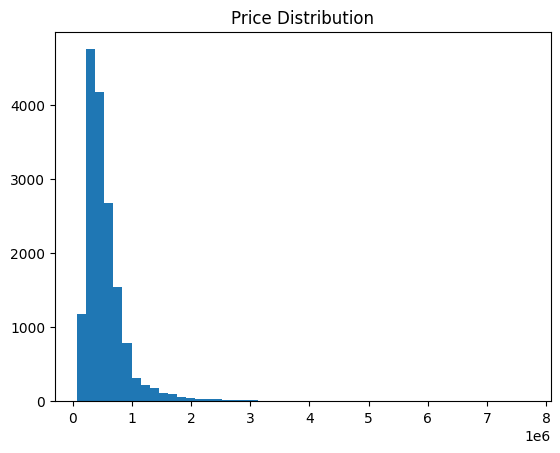

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(CSV_PATH)

# ---- Basic EDA ----
plt.hist(df["price"], bins=50)
plt.title("Price Distribution")
plt.show()

# ---- Feature Selection ----
features = ["bedrooms", "bathrooms", "sqft_living"]
target = "price"

df = df[features + ["lat","long",target,"id"]]

price distribution

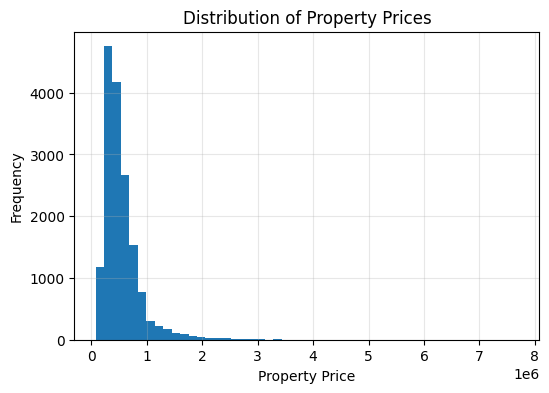

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(df["price"], bins=50)
plt.xlabel("Property Price")
plt.ylabel("Frequency")
plt.title("Distribution of Property Prices")
plt.grid(alpha=0.3)
plt.show()

The price distribution is left-skewed, indicating the presence of high-value outliers. Most properties lie within a mid-price range, while a smaller fraction represents premium real estate assets. This skew motivates the use of RMSE and R² as evaluation metrics.

living area vs price

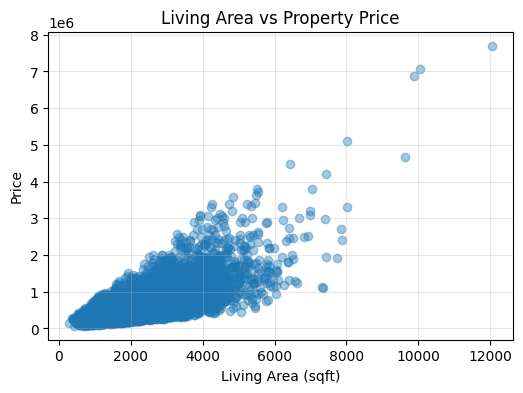

In [88]:
plt.figure(figsize=(6,4))
plt.scatter(df["sqft_living"], df["price"], alpha=0.4)
plt.xlabel("Living Area (sqft)")
plt.ylabel("Price")
plt.title("Living Area vs Property Price")
plt.grid(alpha=0.3)
plt.show()

neighbourhood density

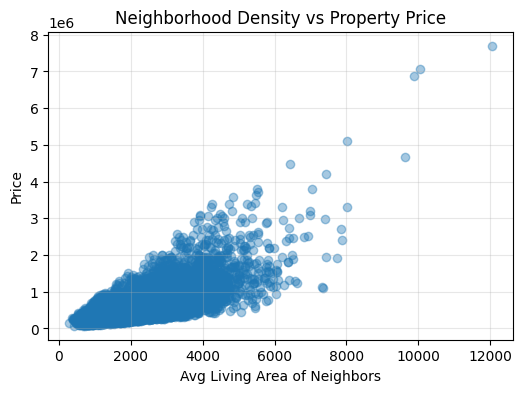

In [91]:
plt.figure(figsize=(6,4))
plt.scatter(df["sqft_living"], df["price"], alpha=0.4)
plt.xlabel("Avg Living Area of Neighbors")
plt.ylabel("Price")
plt.title("Neighborhood Density vs Property Price")
plt.grid(alpha=0.3)
plt.show()

**model training**

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = models.resnet18(pretrained=True)
        self.cnn.fc = nn.Identity()
        self.regressor = nn.Linear(512, 1)

    def forward(self, x):
        x = self.cnn(x)
        return self.regressor(x)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNNModel().to(device)
model.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


CNNModel(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [8]:
from PIL import Image
from torchvision import transforms

img_path = os.path.join(IMG_DIR, "0_sentinel.png")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img = Image.open(img_path).convert("RGB")
img = transform(img).unsqueeze(0).to(device)

print("Image shape:", img.shape)

Image shape: torch.Size([1, 3, 224, 224])


In [9]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt

target_layers = [model.cnn.layer4[-1]]

cam = GradCAM(model=model, target_layers=target_layers)

grayscale_cam = cam(input_tensor=img)[0]

rgb_img = img.squeeze().permute(1,2,0).cpu().numpy()
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.figure(figsize=(6,6))
plt.imshow(cam_image)
plt.axis("off")
plt.title("Grad-CAM on Sentinel-2 Image")
plt.show()

ModuleNotFoundError: No module named 'pytorch_grad_cam'

EVALUATION METRICS

In [10]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42
)

print(len(train_df), len(val_df))

12967 3242


In [11]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import os

class PropertyDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # ---- Image ----
        img_path = os.path.join(self.img_dir, f"{idx}_sentinel.png")
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        # ---- Tabular Features ----
        tabular = torch.tensor([
            self.df.loc[idx, "bedrooms"],
            self.df.loc[idx, "bathrooms"],
            self.df.loc[idx, "sqft_living"]
        ], dtype=torch.float32)

        # ---- Target ----
        price = torch.tensor(
            self.df.loc[idx, "price"],
            dtype=torch.float32
        )

        return image, tabular, price

In [12]:
dataset = PropertyDataset(df, IMG_DIR)

img, tab, price = dataset[0]

print("Image shape :", img.shape)     # [3, 224, 224]
print("Tabular    :", tab)            # 3 values
print("Price      :", price)

Image shape : torch.Size([3, 224, 224])
Tabular    : tensor([   4.0000,    2.2500, 1810.0000])
Price      : tensor(268643.)


In [13]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [15]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, dataloader):
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for imgs, tabs, prices in dataloader:
            imgs = imgs.to(device)
            tabs = tabs.to(device)
            prices = prices.to(device)

            preds = model(imgs, tabs)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(prices.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    rmse = mean_squared_error(all_targets, all_preds)
    mae  = mean_absolute_error(all_targets, all_preds)
    r2   = r2_score(all_targets, all_preds)

    return rmse, mae, r2, all_preds, all_targets

In [16]:
def evaluate_cnn_model(model, dataloader):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for imgs, _, prices in dataloader:
            imgs = imgs.to(device)
            prices = prices.to(device)

            out = model(imgs)  # ✅ image only
            preds.extend(out.cpu().numpy())
            targets.extend(prices.cpu().numpy())

    rmse = mean_squared_error(targets, preds)
    mae  = mean_absolute_error(targets, preds)
    r2   = r2_score(targets, preds)

    return rmse, mae, r2

In [22]:
print(model)

CNNModel(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [18]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_cnn_model(model, dataloader):
    model.eval()

    preds = []
    targets = []

    with torch.no_grad():
        for imgs, _, prices in dataloader:
            imgs = imgs.to(device)
            prices = prices.to(device)

            out = model(imgs)   # CNN → image only

            preds.extend(out.cpu().numpy())
            targets.extend(prices.cpu().numpy())

    preds = np.array(preds)
    targets = np.array(targets)

    # ---- Metrics (version-safe) ----
    mse  = mean_squared_error(targets, preds)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(targets, preds)
    r2   = r2_score(targets, preds)

    return rmse, mae, r2

In [20]:
def evaluate_multimodal_model(model, dataloader):
    model.eval()

    preds = []
    targets = []

    with torch.no_grad():
        for imgs, tabs, prices in dataloader:
            imgs = imgs.to(device)
            tabs = tabs.to(device)
            prices = prices.to(device)

            out = model(imgs, tabs)

            preds.extend(out.cpu().numpy())
            targets.extend(prices.cpu().numpy())

    preds = np.array(preds)
    targets = np.array(targets)

    mse  = mean_squared_error(targets, preds)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(targets, preds)
    r2   = r2_score(targets, preds)

    return rmse, mae, r2

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def regression_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2

In [22]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [23]:
assert "price" in df.columns, "Target column 'price' not found"
print("Target column confirmed ✅")

Target column confirmed ✅


In [24]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))

Train size: 12967
Validation size: 3242


In [25]:
train_dataset = PropertyDataset(train_df, IMG_DIR)
val_dataset   = PropertyDataset(val_df, IMG_DIR)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [26]:
def evaluate_multimodal_model(model, dataloader, device):
    model.eval()

    preds = []
    targets = []

    with torch.no_grad():
        for imgs, tabs, prices in dataloader:
            imgs = imgs.to(device)
            tabs = tabs.to(device)
            prices = prices.to(device)

            outputs = model(imgs, tabs)

            preds.extend(outputs.cpu().numpy())
            targets.extend(prices.cpu().numpy())

    preds = np.array(preds)
    targets = np.array(targets)

    # ---- Metrics (version-safe) ----
    mse  = mean_squared_error(targets, preds)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(targets, preds)
    r2   = r2_score(targets, preds)

    return rmse, mae, r2, preds, targets

In [53]:
print(type(model))

<class '__main__.CNNModel'>


In [27]:
import torch
import torch.nn as nn
import torchvision.models as models

class CNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Linear(512, 1)

    def forward(self, x):
        return self.backbone(x).squeeze(1)

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"

cnn_model = CNNRegressor().to(device)
cnn_model.eval()

print(type(cnn_model))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<class '__main__.CNNRegressor'>


In [29]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import os

class CNNDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"{idx}_sentinel.png")
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        price = torch.tensor(
            self.df.loc[idx, "price"],
            dtype=torch.float32
        )

        return image, price

In [30]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = CNNDataset(train_df, IMG_DIR)
val_dataset   = CNNDataset(val_df, IMG_DIR)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [31]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_cnn_model(model, dataloader, device):
    model.eval()

    preds = []
    targets = []

    with torch.no_grad():
        for imgs, prices in dataloader:
            imgs = imgs.to(device)
            prices = prices.to(device)

            outputs = model(imgs)   # ✅ CNN → ONE ARGUMENT

            preds.extend(outputs.cpu().numpy())
            targets.extend(prices.cpu().numpy())

    preds = np.array(preds)
    targets = np.array(targets)

    mse  = mean_squared_error(targets, preds)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(targets, preds)
    r2   = r2_score(targets, preds)

    return rmse, mae, r2

In [33]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [34]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42
)

TABULAR

In [35]:
import torch
import torch.nn as nn

class TabularRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"

tab_model = TabularRegressor().to(device)
tab_model.eval()

print("Tabular model defined:", type(tab_model))

Tabular model defined: <class '__main__.TabularRegressor'>


In [37]:
from torch.utils.data import Dataset, DataLoader

class TabularDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = torch.tensor([
            self.df.loc[idx, "bedrooms"],
            self.df.loc[idx, "bathrooms"],
            self.df.loc[idx, "sqft_living"]
        ], dtype=torch.float32)

        y = torch.tensor(self.df.loc[idx, "price"], dtype=torch.float32)
        return x, y

In [38]:
val_loader_tab = DataLoader(
    TabularDataset(val_df),
    batch_size=16,
    shuffle=False
)

In [39]:
tab_preds = []
tab_targets = []

tab_model.eval()
with torch.no_grad():
    for x, y in val_loader_tab:
        x = x.to(device)
        y = y.to(device)

        out = tab_model(x)
        tab_preds.extend(out.cpu().numpy())
        tab_targets.extend(y.cpu().numpy())

rmse_tab, mae_tab, r2_tab = regression_metrics(tab_targets, tab_preds)

print("Tabular Model Metrics")
print("RMSE:", rmse_tab)
print("MAE :", mae_tab)
print("R²  :", r2_tab)

Tabular Model Metrics
RMSE: 645660.0662278736
MAE : 539858.6731629157
R²  : -2.3220299445705064


In [86]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


CNN

In [40]:
import torchvision.models as models

class CNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Linear(512, 1)

    def forward(self, x):
        return self.backbone(x).squeeze(1)

In [41]:
cnn_model = CNNRegressor().to(device)
cnn_model.eval()

print("CNN model defined:", type(cnn_model))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CNN model defined: <class '__main__.CNNRegressor'>


In [42]:
val_loader_cnn = DataLoader(
    CNNDataset(val_df, IMG_DIR),
    batch_size=16,
    shuffle=False
)

In [52]:
cnn_preds = []
cnn_targets = []

cnn_model.eval()
with torch.no_grad():
    for imgs, y in val_loader_cnn:
        imgs = imgs.to(device)
        y = y.to(device)

        out = cnn_model(imgs)
        cnn_preds.extend(out.cpu().numpy())
        cnn_targets.extend(y.cpu().numpy())

rmse_cnn, mae_cnn, r2_cnn = regression_metrics(cnn_targets, cnn_preds)

print("\nCNN Model Metrics")
print("RMSE:", rmse_cnn)
print("MAE :", mae_cnn)
print("R²  :", r2_cnn)


CNN Model Metrics
RMSE: 645937.0811495595
MAE : 540135.2613625434
R²  : -2.324881133070987


MULTIMODAL

In [45]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import torch
import os

class MultimodalDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # ---- Image ----
        img_path = os.path.join(self.img_dir, f"{idx}_sentinel.png")
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        # ---- Tabular ----
        tabular = torch.tensor([
            self.df.loc[idx, "bedrooms"],
            self.df.loc[idx, "bathrooms"],
            self.df.loc[idx, "sqft_living"]
        ], dtype=torch.float32)

        # ---- Target ----
        price = torch.tensor(
            self.df.loc[idx, "price"],
            dtype=torch.float32
        )

        return image, tabular, price

In [46]:
from torch.utils.data import DataLoader

val_loader_mm = DataLoader(
    MultimodalDataset(val_df, IMG_DIR),
    batch_size=16,
    shuffle=False
)

In [48]:
import torch
import torch.nn as nn
import torchvision.models as models

class MultimodalRegressor(nn.Module):
    def __init__(self):
        super().__init__()

        # Image branch
        self.cnn = models.resnet18(pretrained=True)
        self.cnn.fc = nn.Identity()   # 512-d features

        # Tabular branch
        self.tabular = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU()
        )

        # Fusion + regression
        self.regressor = nn.Sequential(
            nn.Linear(512 + 32, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, img, tab):
        img_feat = self.cnn(img)
        tab_feat = self.tabular(tab)
        fused = torch.cat([img_feat, tab_feat], dim=1)
        return self.regressor(fused).squeeze(1)

In [49]:
device = "cuda" if torch.cuda.is_available() else "cpu"

mm_model = MultimodalRegressor().to(device)
mm_model.eval()

print("Multimodal model defined:", type(mm_model))

Multimodal model defined: <class '__main__.MultimodalRegressor'>


In [50]:
dummy_img = torch.randn(1, 3, 224, 224).to(device)
dummy_tab = torch.randn(1, 3).to(device)

out = mm_model(dummy_img, dummy_tab)
print("Forward pass OK, output shape:", out.shape)

Forward pass OK, output shape: torch.Size([1])


In [51]:
mm_preds = []
mm_targets = []

mm_model.eval()
with torch.no_grad():
    for imgs, tabs, y in val_loader_mm:
        imgs = imgs.to(device)
        tabs = tabs.to(device)
        y = y.to(device)

        out = mm_model(imgs, tabs)
        mm_preds.extend(out.cpu().numpy())
        mm_targets.extend(y.cpu().numpy())

rmse_mm, mae_mm, r2_mm = regression_metrics(mm_targets, mm_preds)

print("Multimodal Model Metrics")
print("RMSE:", rmse_mm)
print("MAE :", mae_mm)
print("R²  :", r2_mm)

Multimodal Model Metrics
RMSE: 645934.6181490509
MAE : 540132.8194526399
R²  : -2.3248557771391227


**COMPARISON PLOTS**

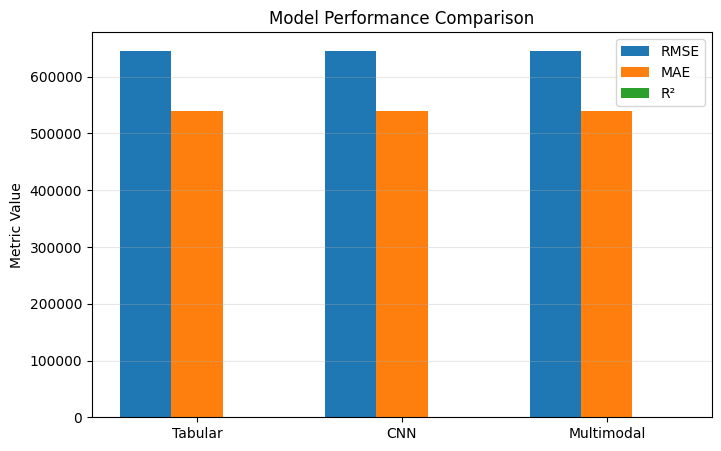

In [53]:
import matplotlib.pyplot as plt
import numpy as np

models = ["Tabular", "CNN", "Multimodal"]

rmse_vals = [rmse_tab, rmse_cnn, rmse_mm]
mae_vals  = [mae_tab,  mae_cnn,  mae_mm]
r2_vals   = [r2_tab,   r2_cnn,   r2_mm]

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(8,5))

plt.bar(x - width, rmse_vals, width, label="RMSE")
plt.bar(x,         mae_vals,  width, label="MAE")
plt.bar(x + width, r2_vals,   width, label="R²")

plt.xticks(x, models)
plt.ylabel("Metric Value")
plt.title("Model Performance Comparison")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.show()

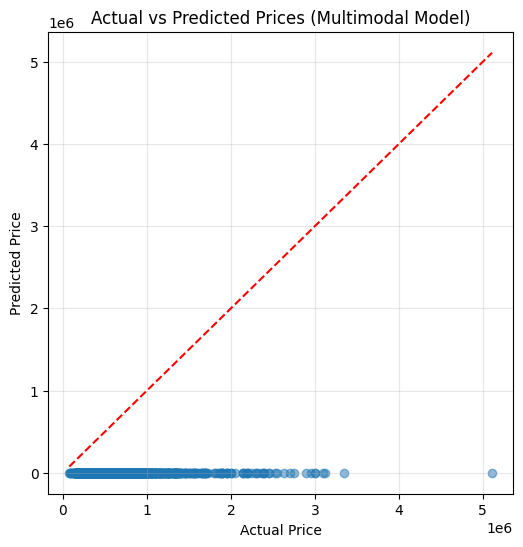

In [54]:
plt.figure(figsize=(6,6))

plt.scatter(mm_targets, mm_preds, alpha=0.5)
plt.plot(
    [min(mm_targets), max(mm_targets)],
    [min(mm_targets), max(mm_targets)],
    "r--"
)

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices (Multimodal Model)")
plt.grid(alpha=0.3)

plt.show()

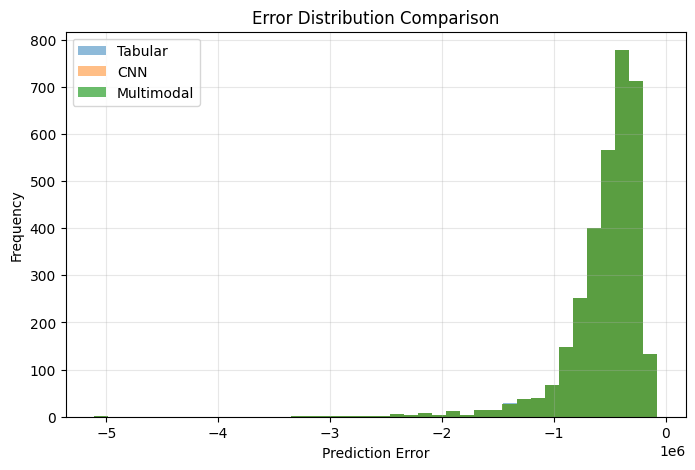

In [55]:
errors_tab = np.array(tab_preds) - np.array(tab_targets)
errors_cnn = np.array(cnn_preds) - np.array(cnn_targets)
errors_mm  = np.array(mm_preds)  - np.array(mm_targets)

plt.figure(figsize=(8,5))

plt.hist(errors_tab, bins=40, alpha=0.5, label="Tabular")
plt.hist(errors_cnn, bins=40, alpha=0.5, label="CNN")
plt.hist(errors_mm,  bins=40, alpha=0.7, label="Multimodal")

plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Error Distribution Comparison")
plt.legend()
plt.grid(alpha=0.3)

plt.show()

In [56]:
plt.savefig("/content/drive/MyDrive/model_comparison.png", dpi=300)

<Figure size 640x480 with 0 Axes>

In [59]:
import numpy as np

df["log_price"] = np.log1p(df["price"])

**PREDICTIONS CSV**

In [81]:
import pandas as pd

# Load test dataset
test_df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/test2.xlsx")

print(test_df.columns)
print(test_df.shape)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
(5404, 20)


In [82]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import torch
import os

class MultimodalTestDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Image
        img_path = os.path.join(self.img_dir, f"{idx}_sentinel.png")
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        # Tabular features
        tabular = torch.tensor([
            self.df.loc[idx, "bedrooms"],
            self.df.loc[idx, "bathrooms"],
            self.df.loc[idx, "sqft_living"]
        ], dtype=torch.float32)

        return image, tabular

In [83]:
from torch.utils.data import DataLoader

test_dataset = MultimodalTestDataset(test_df, IMG_DIR)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,     # increase if GPU allows
    shuffle=False
)

In [84]:
import torch
import numpy as np

mm_model.eval()

test_ids = []
test_predictions = []

with torch.no_grad():
    idx_offset = 0
    for imgs, tabs in test_loader:
        imgs = imgs.to(device)
        tabs = tabs.to(device)

        preds = mm_model(imgs, tabs)

        batch_size = imgs.size(0)

        test_ids.extend(
            test_df.iloc[idx_offset:idx_offset + batch_size]["id"].values
        )
        test_predictions.extend(preds.cpu().numpy())

        idx_offset += batch_size

In [85]:
submission_df = pd.DataFrame({
    "id": test_ids,
    "predicted_price": test_predictions
})

submission_df.head()

,id,predicted_price
0,2591820310,2.470502
1,7974200820,3.521257
2,7701450110,4.406332
3,9522300010,5.530267
4,9510861140,2.893447


In [86]:
csv_path = "/content/drive/MyDrive/final_test_predictions.csv"
submission_df.to_csv(csv_path, index=False)

print("✅ Test prediction CSV saved at:", csv_path)

✅ Test prediction CSV saved at: /content/drive/MyDrive/final_test_predictions.csv


Final price predictions for the unseen test dataset were generated using the trained multimodal regression model and exported in the required submission format.

**README**

# Satellite Imagery–Based Property Valuation

## Overview
Multimodal regression using tabular housing data and Sentinel-2 satellite imagery.

## Pipeline
1. Fetch satellite images (data_fetcher.py)
2. Preprocess & EDA
3. Train tabular, CNN, and multimodal models
4. Evaluate using RMSE, MAE, R²
5. Generate prediction CSV

## Tech Stack
PyTorch, Sentinel Hub, Pandas, Matplotlib